#### Introduction au Machine Learning MINES ParisTech PSL (1A)
## Dimensional reduction & Clustering  - Reddit example
simon.tamayo@mines-paristech.fr

This tutorial is one of the demos used in the course “Introduction to Machine Learning” at MINES ParisTech - PSL Research University, lectured by Simon Tamayo.
#### Acknowledgement
Most of this demo was adapted from the works of @nicolaskruchten (from DataCratic). A more detailed explanaition of this implementation was given by N. Kruchten in [this video](https://youtu.be/2lpS6gUwiJQ), the original version of his code can be found [here](http://opensource.datacratic.com/mtlpy50/).

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [9, 6]
# plt.style.use('ggplot')

### Inspect data

In [3]:
data_path = './data/reddit-user-posting-behavior.csv'
pd.read_csv(data_path,nrows=10, names=["user"]+list(range(25))).fillna("")

,user,0,1,2,3,4,5,6,7,8,...,15,16,17,18,19,20,21,22,23,24
0,603,politics,trees,pics,,,,,,,...,,,,,,,,,,
1,604,Metal,AskReddit,tattoos,redditguild,WTF,cocktails,pics,funny,gaming,...,trackers,Minecraft,gainit,,,,,,,
2,605,politics,IAmA,AdviceAnimals,movies,smallbusiness,Republican,todayilearned,AskReddit,WTF,...,atheism,Jeep,Music,grandrapids,reddit.com,videos,yoga,GetMotivated,bestof,ShitRedditSays
3,606,CrohnsDisease,birthcontrol,IAmA,AdviceAnimals,AskReddit,Endo,WTF,TwoXChromosomes,pics,...,Cartalk,aww,,,,,,,,
4,607,space,Fitment,cars,Economics,Libertarian,240sx,UserCars,AskReddit,WTF,...,Drifting,Justrolledintotheshop,atheism,gadgets,videos,business,gamernews,Cartalk,worldnews,carporn
5,608,politics,Flagstaff,Rainmeter,fffffffuuuuuuuuuuuu,pcgaming,screenshots,truegaming,AdviceAnimals,Guildwars2,...,SuggestALaptop,battlefield3,WTF,starcraft,creepy,pics,funny,darksouls,books,gaming
6,609,Clarinet,AdviceAnimals,festivals,SubredditDrama,InternetAMA,AskReddit,aves,cringe,MemesIRL,...,,,,,,,,,,
7,610,RedHotChiliPeppers,fffffffuuuuuuuuuuuu,tifu,civ,gameofthrones,IAmA,AdviceAnimals,movies,explainlikeimfive,...,skyrim,WTF,germany,pics,funny,seduction,circlebroke,sto,gaming,4chan
8,611,beertrade,AskReddit,WTF,beer,batman,BBQ,beerporn,Homebrewing,,...,,,,,,,,,,
9,612,politics,2012Elections,Parenting,IAmA,fresno,picrequests,AskReddit,loseit,WTF,...,RedditLaqueristas,atheism,LadyBoners,GradSchool,,,,,,


### Load data into a sparse matrix
In numerical analysis and computer science, a sparse matrix or sparse array is a matrix in which most of the elements are zero. By contrast, if most of the elements are nonzero, then the matrix is considered dense. The number of zero-valued elements divided by the total number of elements (e.g., m × n for an m × n matrix) is called the sparsity of the matrix (which is equal to 1 minus the density of the matrix).

In this case we want a matrix: rows are subreddits, columns are users
cells will be 1 if user posted to subreddit, otherwise 0

In [4]:
%%time
user_ids = [] # IDs of users
subreddit_ids = [] # IDs of subreddits
subreddit_to_id = {} # Dictionnary containing which the names of the subreddit IDs
i=0
# Open file
with open(data_path, 'r') as f:
    # Iterate through lines
    for line in f:
        # Split lines using commas
        for sr in line.rstrip().split(",")[1:]: 
            # If the subreddit is new: add it
            if sr not in subreddit_to_id:
                subreddit_to_id[sr] = len(subreddit_to_id)
            user_ids.append(i)
            subreddit_ids.append(subreddit_to_id[sr])
        i+=1

CPU times: user 3.7 s, sys: 111 ms, total: 3.81 s
Wall time: 3.85 s


In [5]:
import numpy as np
from scipy.sparse import csr_matrix 

In [6]:
rows = np.array(subreddit_ids)
cols = np.array(user_ids)
data = np.ones((len(user_ids),))
num_rows = len(subreddit_to_id)
num_cols = i

# csr_matrix returns a Compressed Sparse Row matrix
adj = csr_matrix( (data,(rows,cols)), shape=(num_rows, num_cols) )
print(adj.shape)

# now we have our matrix, so let's gather up a bit of info about it
users_per_subreddit = adj.sum(axis=1).A1
subreddits = list(range(len(subreddit_to_id)))
for sr in subreddit_to_id:
    subreddits[subreddit_to_id[sr]] = sr
subreddits = np.array(subreddits)

print('percentage of the matrix that has information: ')
print(round(adj.sum()/(adj.shape[0]*adj.shape[1])*100,4))

(15122, 876961)
percentage of the matrix that has information: 
0.0641


In [7]:
print(len(subreddits))
print(len(user_ids))

15122
8495597


In [8]:
adj.toarray()

array([[1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Dimensionality reduction
We use TruncatedSVD from scikit-learn. SVD stands for Singular Vector Decomposition

(15122, 100)
CPU times: user 47 s, sys: 7.7 s, total: 54.7 s
Wall time: 48.2 s


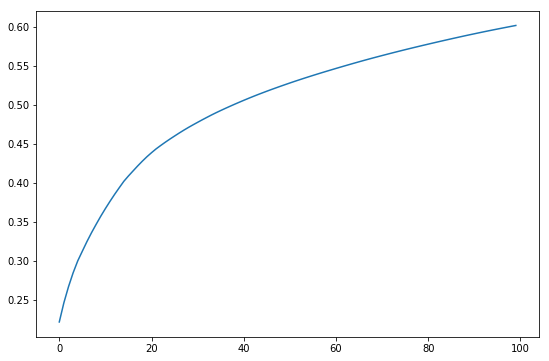

In [9]:
%%time
from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import normalize 
svd = TruncatedSVD(n_components=100)
embedded_coords = normalize(svd.fit_transform(adj), norm='l1')
print(embedded_coords.shape)
plt.plot(np.cumsum(svd.explained_variance_ratio_))

### A few interesting dimensions (pandas viz)

In [10]:
pd.DataFrame(subreddits[np.argsort(embedded_coords[:,[0,1,2,3,4]], axis=0)[::-1]], 
             columns=['0','1','2','3','4'])

,0,1,2,3,4
0,AskReddit,AskReddit,AskReddit,gaming,AdviceAnimals
1,funny,marathi,YUNoTakeMyMoney,csgoworldTV,FUCKuLEVI
2,pics,novafactory,classyclub,Crawle,stgregoryschool
3,WTF,YUNoTakeMyMoney,marathi,PictureswithSquidward,pennstate
4,gaming,classyclub,PsiUEI,picsofdeadbunnies,girlsontheirbacks
5,AdviceAnimals,Factories,Factories,Finmark,childishgambino
6,IAmA,deandrefall,novafactory,ShittyHub,CalifornianProblems
7,videos,violentpornography,kasperrosa,Superjail,HMpyongyang
8,todayilearned,necroporn,superheroinesdefeated,2DawnGames,SoftcoreNSFW_GIF
9,atheism,superheroinesdefeated,violentpornography,gamedynamo,Badluckbrian


### Visualizing these dimensions with bokeh

In [11]:
import bokeh.plotting as bp
from bokeh.io import output_notebook
from bokeh.models import HoverTool
output_notebook()

Loading BokehJS ...

#### Keep only subreddits with more than a given number of users

In [12]:
row_selector = np.where(users_per_subreddit>100)

In [13]:
#### Plot the data using the first 2 singular vector 

In [14]:
f = bp.figure(plot_width=800, plot_height=600, 
          title="Subreddit Map",
          x_axis_label = "Singular vector 0",
          y_axis_label = "Singular vector 1",
          tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
       min_border=1)

source = bp.ColumnDataSource(data=dict(x=embedded_coords[:,0][row_selector], 
                                       y=embedded_coords[:,1][row_selector],
                                      subreddit=subreddits[row_selector],
                                      radius = np.log2(users_per_subreddit[row_selector])/4000))
f.scatter(x='x', y='y', radius='radius', source=source,alpha=0.55)
f.hover.tooltips=[( 'subreddit','@subreddit')]
bp.show(f)

### Do clustering in order to colour-code by overall distance
Clustering correspond to the family of algorithms for grouping items into buckets

In [15]:
%%time
from scipy.stats import rankdata
from sklearn.cluster import KMeans

embedded_ranks = np.array([rankdata(c) for c in embedded_coords.T]).T
n_clusters = 50
km = KMeans(n_clusters)
# clusters = km.fit_predict(embedded_ranks)
clusters = km.fit_predict(embedded_coords)

CPU times: user 11.9 s, sys: 397 ms, total: 12.3 s
Wall time: 6.33 s


#### Let's visualize some the first 4 clusters

In [16]:
pd.DataFrame([subreddits[clusters == i][users_per_subreddit[clusters == i].argsort()[:4][::-1]] for i in range(n_clusters)])

,0,1,2,3
0,trueblackfathers,APC,truenews,nflgifs
1,backgroundponies,mylittlekorra,MLPLite,Bacon7
2,26thworldproblems,easterneurope,frontiama,MITocw600
3,WillaHolland,GIFSwithSombreros,TvShowBandNames,kittiesonkeyboards
4,freddiemercury,BigEastFootball,fightingillini,fanduel
5,dreamjobs,joowz,Poker_Women,wetandwild
6,GetOffMyLawn,eggs,Hypercritical,anticreationism
7,ParisSG,kinkyoffensiveshit,ImperialLawCo,godwinslaw
8,whatsthat,GoodWomen,SuperMight,loadouts
9,Dortmund,Indianpolitics,HalfbuiltHistory,agi


#### Assign random colors to the clusters

In [17]:
colors = []
for i in range(n_clusters):
    colors.append('%06X' % np.random.randint(0, 0xFFFFFF))

#### Plot clustered data using the first 2 principal components

In [18]:
colormap = np.array(colors)
f = bp.figure(plot_width=800, plot_height=600, 
          title="Subreddit Map by Interesting Dimensions",
          x_axis_label = "Singular vector 0",
          y_axis_label = "Singular vector 1",
          tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
       min_border=1)

source = bp.ColumnDataSource(data=dict(x=embedded_coords[:,0][row_selector], 
                                       y=embedded_coords[:,1][row_selector],
                                      subreddit=subreddits[row_selector],
                                      radius = np.log2(users_per_subreddit[row_selector])/5000,
                                      color = colormap[clusters[row_selector]]))

f.scatter(x='x', y='y', radius='radius', source=source, color='color', alpha=0.55)
f.hover.tooltips=[( 'subreddit','@subreddit')]
bp.show(f)

### Manifold learning : AKA low-dimensional embedding
Family of algorithms to transform many dimensions to 2 or 3. In this part We use TSNE (t-distributed Stochastic Neighbor Embedding) from scikit-learn.

In [19]:
%%time
from sklearn.manifold import TSNE
xycoords = TSNE(random_state=66,
                perplexity=50).fit_transform(embedded_coords[row_selector])

CPU times: user 1min 23s, sys: 6.99 s, total: 1min 30s
Wall time: 1min 30s


### Visualize the result of the TNSE algorithm

In [20]:
bp.reset_output()
f = bp.figure(plot_width=900, plot_height=700, title="Subreddit Map by t-SNE",
       tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
       x_axis_type=None, y_axis_type=None, min_border=1)
source = bp.ColumnDataSource(data=dict(x=xycoords[:,0], 
                                       y=xycoords[:,1],
                                       subreddit=subreddits[row_selector],
                                       radius=np.log2(users_per_subreddit[row_selector])/20,
                                       color=colormap[clusters[row_selector]]))
f.scatter(x='x', y='y', radius='radius', source=source, color='color', alpha=0.5)
f.hover.tooltips=[( 'subreddit','@subreddit')]
bp.show(f)
bp.output_file('reddit_LSA_result.html')
bp.save(f)

'/Users/simontamayo/ownCloud/mines/machine_learning/intro_au_ml_1A_simon_tamayo/demos/reddit_unsup/reddit_LSA_result.html'